# PHYS 2201
## Computational Assignment 2

This notebook provides some examples for the integration of particle position in a two-dimensional prescribed flow field, according to

\begin{equation} 
\frac{d\mathbf{x}}{dt} = \mathbf{u} \quad \quad  \quad \quad  (1)
\end{equation}

to help you get a start on question 1.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

### Example flow field

We will use an example flow field which describes a single vortex located at $\mathbf{x} = (\beta,0)$ written

\begin{align}
    u(x,y) &= \frac{- \alpha y}{(x-\beta)^2 + y^2}  \\
    v(x,y) &= \frac{\alpha(x-\beta)}{(x-\beta)^2 + y^2} 
\end{align}

where we will generally use $\alpha=1$ and $\beta=0.4$.

Let's construct this velocity field as a function:

In [3]:
def calculate_velocity(alpha, beta, x, y):
    u = - alpha*y/((x-beta)**2 + y**2) 
    v = alpha*(x-beta)/((x-beta)**2 + y**2)
    return u,v

Then, let's plot this field using the `streamplot` function.

Text(0,0.5,'y')

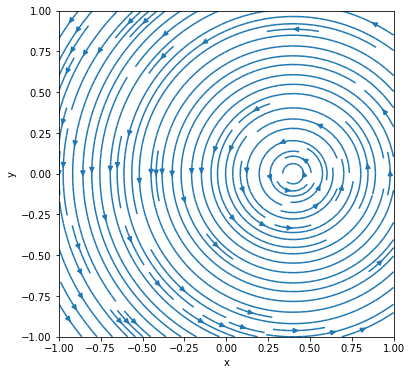

In [7]:
y = np.linspace(-1,1,200)
x = np.linspace(-1,1,200)
X,Y = np.meshgrid(x,y)

u,v = calculate_velocity(1,0.4,X,Y)

plt.figure(figsize=(6,6))
plt.streamplot(x,y,u,v,density=1.5)
plt.xlim([-1, 1])
plt.xlabel('x')
plt.ylabel('y')

You can see that any particle placed in this flow field should simply orbit around the point $(\beta,0)$.

Next, let's look at a couple of different methods that you can use to explicitly solve for particle trajectories in this field.

### The simplest way: forward differences

Let's discretise Equation (1) in the time domain. In short, this means that you approximate the time derivative of particle position, $\mathbf{x}$ as 
$$\frac{d\mathbf{x}}{dt} \approx \frac{\mathbf{x}_{t+1} - \mathbf{x}_t}{\Delta t} $$
where $\mathbf{x}_t$ is the position at time $t$, and $\mathbf{x}_{t+1}$ is the position at time $t + \Delta t$.
In the limit of $\Delta t \to 0$ this expression becomes exact.

We can rearrange this expression, in combination with Eq. (1), to write
$$
\begin{align}
x_{t+1} &= x_t + \Delta t u\\
y_{t+1} &= y_t + \Delta t v
\end{align}
$$
in which the RHS is now known.
Accordingly we can now step forward, $\Delta t$ at a time, to follow the particle path using the function `odestep`.

In [20]:
def odestep(xinit, yinit, time, dt):
    nt = np.int(time/dt)
    x=np.append([],xinit)
    y=np.append([],yinit)
    for i in range (nt):
        x0 = x[-1]
        y0 = y[-1]
        t=i*dt
        #print(t)
        u,v = calculate_velocity(1, 0.4, x0, y0)
        x = np.append(x,x0+dt*u)
        y = np.append(y,y0+dt*v)
    plt.plot(x,y,linewidth=2,label='trajectory')
    plt.plot(xinit,yinit,'*',label='initial')
    plt.plot(x[-1],y[-1],'o',label='final')

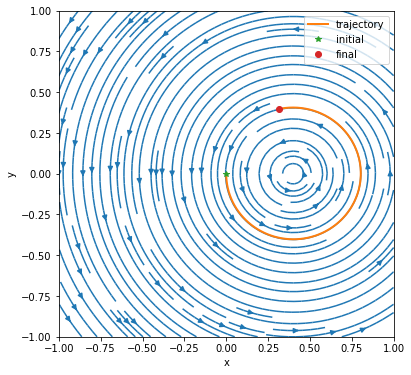

In [35]:
plt.figure(figsize=(6,6))
plt.streamplot(x,y,u,v,density=1.5)
odestep(0.0, 0.0, 0.8, 0.001)
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

This *forward difference* method is a very low-order scheme, which means it has large numerical errors.
But it is the easiest to code and the easiest to understand.

### A better way: Runge Kutta 4th order

Higher order numerical methods essentially aim to have a more accurate estimate of the derivative.

\begin{equation}
    y'(t) = f(t,y(t))
\end{equation}
over $[t_0,t_1]$ with $y(t_0)=y_0$

To obtain the solution point $(t_1,y_1)$ we can use the fundamental theorem of calculus and integrate $y'(t)$ over $[t_0,t_1]$ to get:
\begin{equation}
\int_{t_o}^{t_1} f(t,y(t))dt = \int_{t_o}^{t_1} y'(t) dt = y(t_1)-y(t_0)
\end{equation}
When solved for  $y(t_1)$ the result is:
\begin{equation}
y(t_1) = y(t_0) + \int_{t_o}^{t_1} f(t,y(t))dt 
\end{equation}

Now, the [fourth-order Runge-Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods) approximates this integral as:
\begin{equation}
y_{i+1} = y_i + \frac{h}{6}(k_1,2k_2+2k_3+k_4)
\end{equation}
where:
\begin{equation}
k_1=f(t_i,y_i)
\end{equation}

\begin{equation}
k_2=f(t_i+\frac{1}{2}h,y_i+\frac{1}{2}hk_1)
\end{equation}

\begin{equation}
k_3=f(t_i+\frac{1}{2}h,y_i+\frac{1}{2}hk_2)
\end{equation}

\begin{equation}
k_4=f(t_i+h,y_i+hk_3)
\end{equation}

In [25]:
# Runge-Kutta 4th Order Function:
def rK4(t0, y0, h):
    '''
    Finds value of y(t0+h) for a given t0 and y0
    '''
    
    k1 = h*model(t0, y0)
    k2 = h*model(t0 + 0.5*h, y0 + 0.5*k1)
    k3 = h*model(t0 + 0.5*h, y0 + 0.5*k2)
    k4 = h*model(t0 + h, y0 + k3)
        
    y = y0 + (1/6)*(k1+2*k2+2*k3+k4);
    t = t0 + h
    return y

In [26]:
def model(t,vec):
    X,Y=vec
    dxdt=-((alpha*Y)/((X-beta)**2+Y**2))
    dydt=((alpha*(X-beta))/((X-beta)**2+Y**2))
    return np.array([dxdt,dydt])

In [44]:
x0 = 0
y0 = np.array([[0.,0.]])
h  = 0.01
loc= y0
alpha=1
beta=0.4
for ii in range(80):
    loc1=rK4(x0, loc[-1], h)
    loc=np.vstack((loc,loc1))

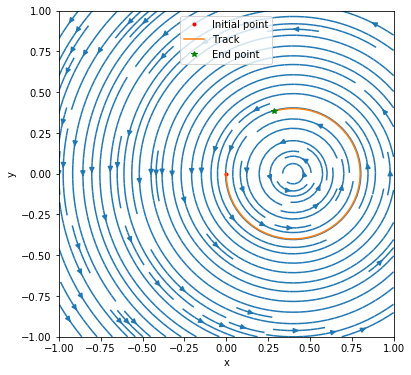

In [45]:
plt.figure(figsize=(6,6))
plt.streamplot(X,Y,u,v,density=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.plot(loc[0,0],loc[0,1],'.r',label='Initial point')
plt.plot(loc[:,0],loc[:,1],'-',label='Track')
plt.plot(loc[-1,0],loc[-1,1],'*g',label='End point')
plt.legend()

### Summary
This notebook gives you a few example of how to do this problem, but you are free to choose the method that suits you best, or to construct your own!